In [68]:
import cv2
import numpy as np
import requests
import io
import torch
from torch import nn
import ttach as tta
import torchvision.transforms as transforms
from PIL import ImageTk, Image
from typing import Callable, List, Tuple
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from torchvision.transforms import Compose, Normalize, ToTensor

In [69]:
from activations import ActivationsAndGradients


from help import preprocess_image,deprocess_image,show_cam_on_image,show_factorization_on_image,scale_cam_image,scale_accross_batch_and_channels

In [70]:

class ClassifierOutputTarget:
    def __init__(self, category):
        print("ClassifierOutputTarget -> init")
        self.category = category

    def __call__(self, model_output):
        print("ClassifierOutputTarget -> call")
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]


In [71]:
def temp_helper(activation_batch):
    activation_batch[np.isnan(activation_batch)] = 0
    projections_train = []
    projections_test = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
             reshaped_activations.mean(axis=0)
        test = np.zeros(reshaped_activations.shape)
        train = reshaped_activations.copy()
        print(train.shape)
        for user in range(reshaped_activations.shape[0]):
            test_index = np.random.choice(
                np.flatnonzero(reshaped_activations[user]), size = 10, replace = False)

            train[user, test_index] = 0.0
            test[user, test_index] = reshaped_activations[user, test_index]
            print("Shape of train and test")
            print(train.shape)
            print(test.shape)
        projection = train.reshape(activations.shape[1:])
        projections_train.append(train)
        projections_test.append(test)
    return np.float32(projections_train),np.float32(projections_test)
        
    

In [72]:
class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []   
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = np.square(np.subtract(y_true[mask], y_pred[mask])).mean() 
        return mse

In [73]:



class BaseCAM:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        print("BaseCam")
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        target_layers: List[torch.nn.Module],
                        targets: List[torch.nn.Module],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        print("get_cam_weights")
        raise Exception("Not Implemented")

    def get_cam_image(self,
                      input_tensor: torch.Tensor,
                      target_layer: torch.nn.Module,
                      targets: List[torch.nn.Module],
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:
        print("get_cam_image")
        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self,
                input_tensor: torch.Tensor,
                targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:
        print("forward")
        if self.cuda:
            input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(
                category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output)
                       for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self,
                                input_tensor: torch.Tensor) -> Tuple[int, int]:
        print("get_target_width_height")
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor: torch.Tensor,
            targets: List[torch.nn.Module],
            eigen_smooth: bool) -> np.ndarray:
        print("compute_cam_per_layer")
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam = np.maximum(cam, 0)
            scaled = scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(
            self,
            cam_per_target_layer: np.ndarray) -> np.ndarray:
        print("aggregate_multi_layers")
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image(result)

    def forward_augmentation_smoothing(self,
                                       input_tensor: torch.Tensor,
                                       targets: List[torch.nn.Module],
                                       eigen_smooth: bool = False) -> np.ndarray:
        print("forward_augmentation_smoothing")
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               targets,
                               eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor: torch.Tensor,
                 targets: List[torch.nn.Module] = None,
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:
        print("__call__")
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth)

        return self.forward(input_tensor,
                            targets, eigen_smooth)

    def __del__(self):
        print("del")
        self.activations_and_grads.release()

    def __enter__(self):
        print("__enter__")
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            print("__exit__")
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

Using cache found in C:\Users\sukan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-9-3 Python-3.9.12 torch-1.12.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


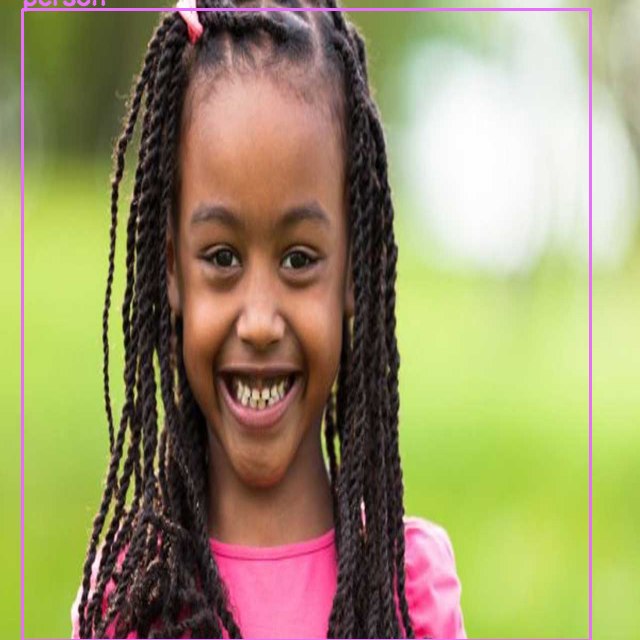

In [112]:
COLORS = np.random.uniform(0,255,size=(80,3))

def parse_detections(results):
  detections = results.pandas().xyxy[0]
  detections = detections.to_dict()
  boxes, colors, names=[],[],[]

  for i in range(len(detections["xmin"])):
    confidence = detections["confidence"][i]
    if confidence < 0.2:
      continue
    xmin = int(detections["xmin"][i])
    ymin = int(detections["ymin"][i])
    xmax = int(detections["xmax"][i])
    ymax = int(detections["ymax"][i])
    name = detections["name"][i]
    category = int(detections["class"][i])
    color = COLORS[category]

    boxes.append((xmin,ymin,xmax,ymax))
    colors.append(color)
    names.append(name)
  return boxes,colors,names

def draw_detections(boxes,colors,names,img):
  for box,color,name in zip(boxes,colors,names):
    xmin,ymin,xmax,ymax = box
    cv2.rectangle(
        img,
        (xmin,ymin),
        (xmax,ymax),
        color,
        2)
    cv2.putText(img,name,(xmin,ymin-5),cv2.FONT_HERSHEY_SIMPLEX,0.8,color,2,lineType=cv2.LINE_AA)
  return img  


      
#image_url = 'https://www.google.com/imgres?imgurl=https%3A%2F%2Fwww.rd.com%2Fwp-content%2Fuploads%2F2021%2F03%2FGettyImages-1133605325-scaled-e1617227898456.jpg%3Ffit%3D696%2C463&imgrefurl=https%3A%2F%2Fwww.rd.com%2Flist%2Fadorable-puppy-pictures%2F&tbnid=Vl6XXH-p6C1XhM&vet=12ahUKEwibm_z2s_b5AhWYk9gFHVUIDAQQMygBegUIARDgAQ..i&docid=-_iTcnLa7aD28M&w=695&h=463&q=picture%20of%20puppies&ved=2ahUKEwibm_z2s_b5AhWYk9gFHVUIDAQQMygBegUIARDgAQ'
#r = requests.get('https://upload.wikimedia.org/wikipedia/commons/f/f1/Puppies_%284984818141%29.jpg',stream=True)
r = requests.get('https://guardian.ng/wp-content/uploads/2022/03/Confident-girls.jpg',stream=True)
img = np.array(Image.open(io.BytesIO(r.content)))
img = cv2.resize(img,(640,640))
rgb_img = img.copy()
img=np.float32(img)/255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model=torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers=[model.model.model.model[-2]]

results=model([rgb_img])
boxes,colors,names=parse_detections(results)
detections = draw_detections(boxes,colors,names,rgb_img.copy())
Image.fromarray(detections)

In [113]:
def random_initialization(A,rank):
    number_of_documents = A.shape[0]
    number_of_terms = A.shape[1]
    W = np.random.uniform(1,2,(number_of_documents,rank))
    H = np.random.uniform(1,2,(rank,number_of_terms))
    return W,H
                          

def nndsvd_initialization(A,rank):
    u,s,v=np.linalg.svd(A,full_matrices=False)
    v=v.T
    w=np.zeros((A.shape[0],rank))
    h=np.zeros((rank,A.shape[1]))

    w[:,0]=np.sqrt(s[0])*np.abs(u[:,0])
    h[0,:]=np.sqrt(s[0])*np.abs(v[:,0].T)

    for i in range(1,(300)):
        
        ui=u[:,i]
        vi=v[:,i]
        ui_pos=(ui>=0)*ui
        ui_neg=(ui<0)*-ui
        vi_pos=(vi>=0)*vi
        vi_neg=(vi<0)*-vi
        
        ui_pos_norm=np.linalg.norm(ui_pos,2)
        ui_neg_norm=np.linalg.norm(ui_neg,2)
        vi_pos_norm=np.linalg.norm(vi_pos,2)
        vi_neg_norm=np.linalg.norm(vi_neg,2)
        
        norm_pos=ui_pos_norm*vi_pos_norm
        norm_neg=ui_neg_norm*vi_neg_norm
        
        if norm_pos>=norm_neg:
            w[:,i]=np.sqrt(s[i]*norm_pos)/ui_pos_norm*ui_pos
            h[i,:]=np.sqrt(s[i]*norm_pos)/vi_pos_norm*vi_pos.T
        else:
            w[:,i]=np.sqrt(s[i]*norm_neg)/ui_neg_norm*ui_neg
            h[i,:]=np.sqrt(s[i]*norm_neg)/vi_neg_norm*vi_neg.T

    return w,h
def mu_method(A,k,max_iter,init_mode='nndsvd'):
    
    if init_mode == 'random':
        W ,H = random_initialization(A,k)
    elif init_mode == 'nndsvd':
        W ,H = nndsvd_initialization(A,k) 
    norms = []
    e = 1.0e-10
    for n in range(max_iter):
        # Update H
        W_TA = W.T@A
        W_TWH = W.T@W@H+e
        for i in range(np.size(H, 0)):
            for j in range(np.size(H, 1)):
                H[i, j] = H[i, j] * W_TA[i, j] / W_TWH[i, j]
        # Update W
        AH_T = A@H.T
        WHH_T =  W@H@H.T+ e

        for i in range(np.size(W, 0)):
            for j in range(np.size(W, 1)):
                W[i, j] = W[i, j] * AH_T[i, j] / WHH_T[i, j]

        norm = np.linalg.norm(A - W@H, 'fro')
        norms.append(norm)
    return W ,H ,norms 

In [114]:
def get_2d_projection(activation_batch):    
    # TBD: use pytorch batch svd implementation
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    print(activation_batch.shape)
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
            reshaped_activations.mean(axis=0)
        print(reshaped_activations.shape)
        W,H,norms = mu_method(reshaped_activations,512,12)
        print(reshaped_activations.shape)
        print(H[0,:].shape)
        projection = reshaped_activations @ H[0, :]
        print(projection.shape)
        projection = projection.reshape(activations.shape[1:])
        print(projection.shape) #(16, 29)
        projections.append(projection)
    print((np.float32(projections)).shape) #(2, 16, 29)
    return np.float32(projections)

In [115]:
def get_2d_projection_old(activation_batch):    
    # TBD: use pytorch batch svd implementation
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
            reshaped_activations.mean(axis=0)
        U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
        projection = reshaped_activations @ VT[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)

In [116]:
class EigenCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        print("Eigen init")
        super(EigenCAM, self).__init__(model,
                                       target_layers,
                                       use_cuda,
                                       reshape_transform,
                                       uses_gradients=False)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        print(type(activations))
        print("get_cam_image")
#         trains,tests = temp_helper(activations)
#         print("Here")
#         print(type(trains))
#         print(trains)
#         print(type(tests))
#         print(tests)
        return get_2d_projection(activations)
#         return get_2d_projection_old(activations)

In [117]:
# print(target_layers)
# print(model)

In [118]:
cam = EigenCAM(model, target_layers, use_cuda=False) 

Eigen init
BaseCam
ActivationsAndGradients -> __init__
del
ActivationsAndGradients -> release


In [119]:
grayscale_cam = cam(tensor)[0, :, :]

__call__
forward
ActivationsAndGradients -> __call__
ActivationsAndGradients -> save_activation
ActivationsAndGradients -> save_gradient
ClassifierOutputTarget -> init
compute_cam_per_layer
get_target_width_height
<class 'numpy.ndarray'>
get_cam_image
(1, 512, 20, 20)
(400, 512)
(400, 512)
(512,)
(400,)
(20, 20)
(1, 20, 20)
scale_cam_image
aggregate_multi_layers
scale_cam_image


In [120]:
print(grayscale_cam)

[[          0           0           0 ...           0           0           0]
 [          0           0           0 ...           0           0           0]
 [          0           0           0 ...           0           0           0]
 ...
 [          0           0           0 ...           0           0           0]
 [          0           0           0 ...           0           0           0]
 [          0           0           0 ...           0           0           0]]


show_cam_on_image


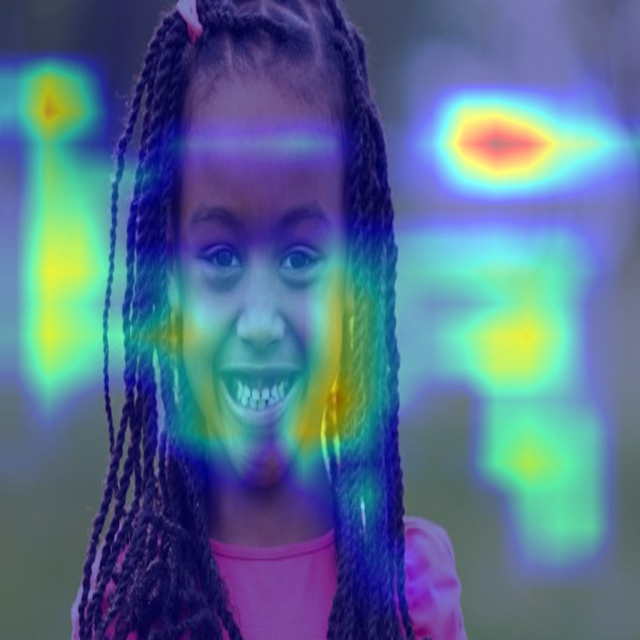

In [121]:

cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

scale_cam_image
scale_cam_image
show_cam_on_image


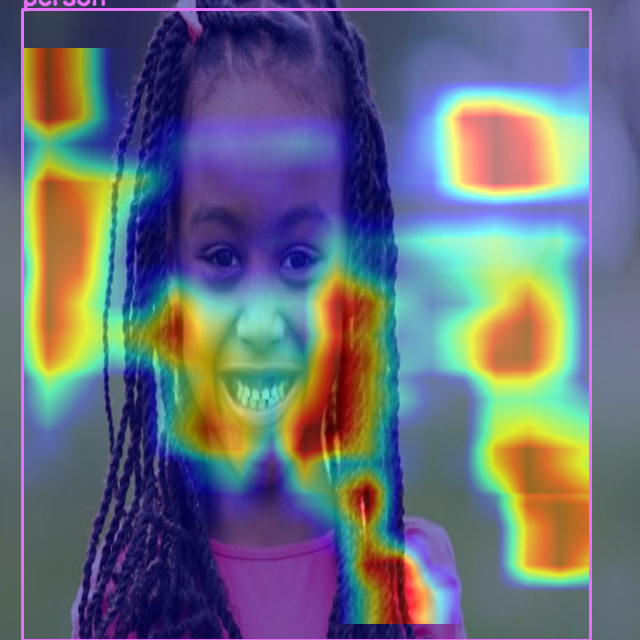

In [122]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)

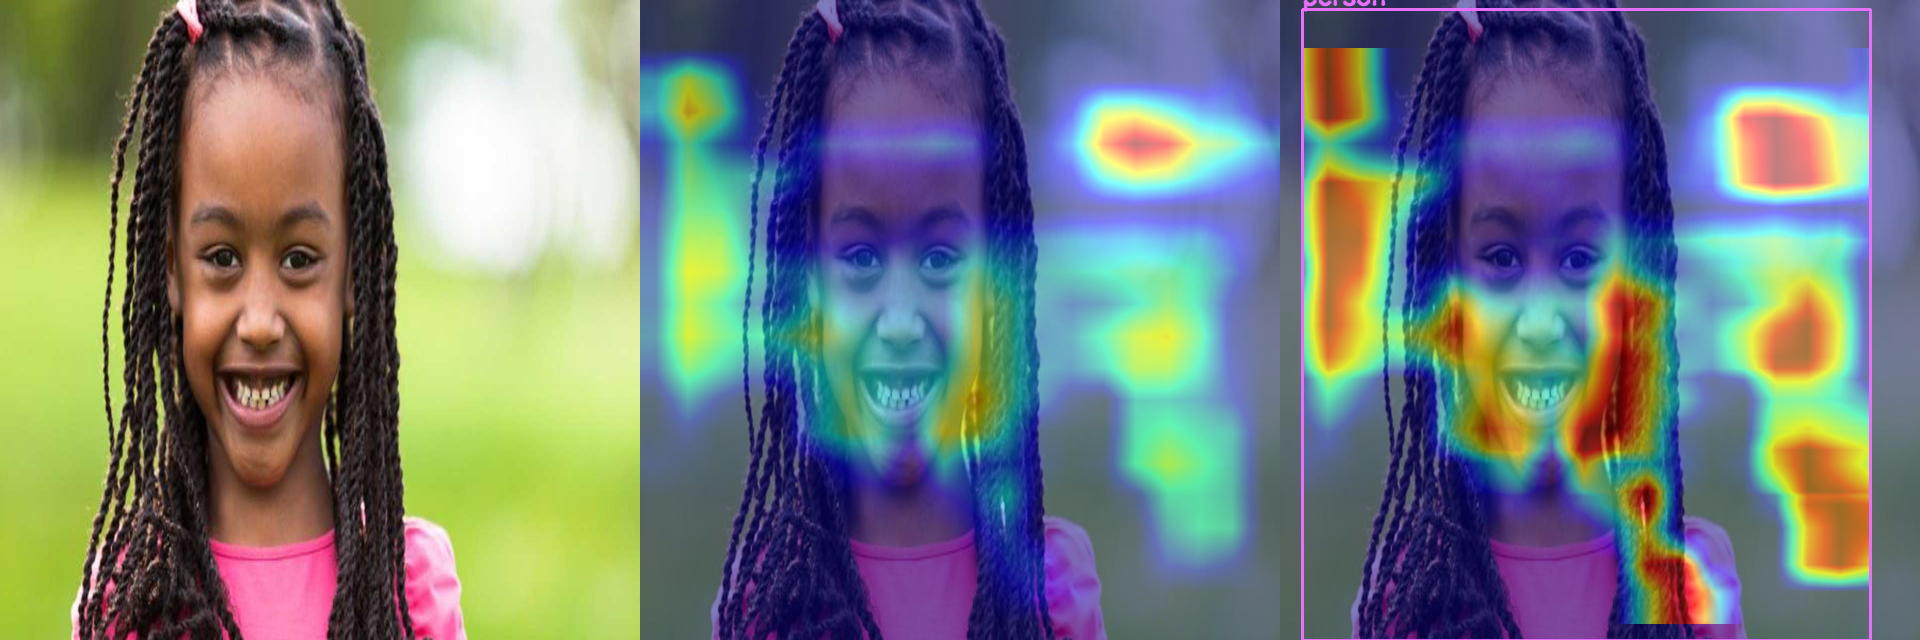

In [123]:
Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))